<h1><center><b>Anamoly Detection AutoEncoder NN Model</b></center></h1>

## Import and Load Dataset

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [2]:
# Load the preprocessed training and test datasets
train_data = pd.read_csv('dataset_preprocessed/Processed_Train.csv')
test_data = pd.read_csv('dataset_preprocessed/Processed_Test.csv')

In [3]:
# Separate features and target from the training dataset
X_train = train_data.drop(columns=['target'])
Y_train = train_data['target']
X_test = test_data.drop(columns=['target'])
Y_test = test_data['target']

In [19]:
X_train_class_1 = X_train[Y_train == 1]
Y_train_class_1 = Y_train[Y_train == 1]
X_test_class_1 = X_test[Y_test == 1]
Y_test_class_1 = Y_test[Y_test == 1]

In [20]:
print(X_train_class_1.shape)
print(Y_train_class_1.shape)
print(X_train.shape)
print(Y_train.shape)

(74033, 25)
(74033,)
(785133, 25)
(785133,)


## Build and train the Encoder (Class 1)

In [100]:
# Define the autoencoder architecture
encoding_dim = 10  # Dimensionality of the encoded space

autoencoder = Sequential()

# Encoder
autoencoder.add(Input(shape=(X_train_class_1.shape[1],)))

autoencoder.add(Dense(32))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(16))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(encoding_dim))
autoencoder.add(LeakyReLU(alpha=0.1))

# Decoder
autoencoder.add(Dense(16))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(32))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(X_train.shape[1]))

autoencoder.add(LeakyReLU(alpha=0.1))

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

/home/siddhesh/miniconda3/envs/env1/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [101]:
# Train the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_train_class_1, X_train_class_1, 
                epochs=100, 
                batch_size=64, 
                shuffle=True, 
                validation_data=(X_test_class_1, X_test_class_1),
                callbacks=[early_stopping])

Epoch 1/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2443 - val_loss: 0.0683
Epoch 2/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0647 - val_loss: 0.0407
Epoch 3/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0465 - val_loss: 0.0319
Epoch 4/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0366 - val_loss: 0.0263
Epoch 5/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0315 - val_loss: 0.0236
Epoch 6/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0253 - val_loss: 0.0230
Epoch 7/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0245 - val_loss: 0.0189
Epoch 8/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0236 - val_loss: 0.0182
Epoch 9/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0224 - val_loss: 0.0162
Epoch 10/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0206 - val_loss: 0.0152
Epoch 11/100
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0202 - val_loss: 0.0149
Epoch 12/100
1157/1

In [102]:
X_train_pred = autoencoder.predict(X_train)

24536/24536 ━━━━━━━━━━━━━━━━━━━━ 21s 849us/step


In [103]:
reconstruction_errors_train = np.mean(np.square(X_train - X_train_pred), axis=1)

In [104]:
# Do the same for X_test
X_test_pred = autoencoder.predict(X_test)
reconstruction_errors_test = np.mean(np.square(X_test - X_test_pred), axis=1)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 7s 793us/step


In [105]:
reconstruction_errors_train = np.array(reconstruction_errors_train)
reconstruction_errors_test = np.array(reconstruction_errors_test)

In [109]:
import xgboost as xgb

# Train a model using reconstruction errors
clf = xgb.XGBClassifier()

# Fit the classifier using the reconstruction errors and Y_train
clf.fit(reconstruction_errors_train.reshape(-1, 1), Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [110]:
Y_pred = clf.predict(reconstruction_errors_test.reshape(-1, 1))

Accuracy: 96.35%

Confusion Matrix:
[[227672   9362]
 [   191  24487]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    237034
           1       0.72      0.99      0.84     24678

    accuracy                           0.96    261712
   macro avg       0.86      0.98      0.91    261712
weighted avg       0.97      0.96      0.97    261712



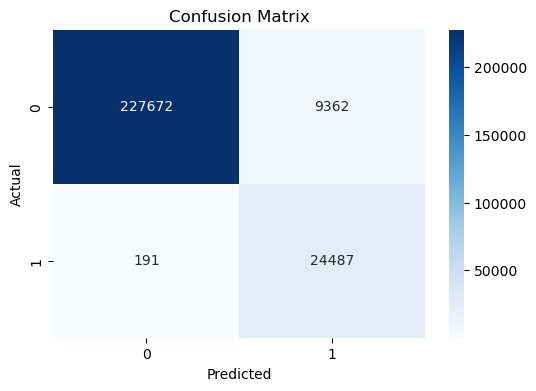

Precision: 0.72
Recall: 0.99
F1-Score: 0.84
ROC-AUC: 0.98


In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Precision, Recall, F1-Score
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

In [139]:
# Define the model
model_meta = Sequential()

model_meta.add(Input(shape=(1,)))

model_meta.add(Dense(4))
model_meta.add(LeakyReLU(alpha=0.1))

model_meta.add(Dense(2))
model_meta.add(LeakyReLU(alpha=0.1))

model_meta.add(Dense(1, activation='sigmoid'))

# Compile the model
model_meta.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Summary of the model
model_meta.summary()

/home/siddhesh/miniconda3/envs/env1/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

In [142]:
tensorboard_callback_meta = tf.keras.callbacks.TensorBoard(log_dir='tf_logs/model_meta_nn', histogram_freq=1)
lr_scheduler_meta = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_meta.fit(reconstruction_errors_train, Y_train, 
          epochs=15, 
          batch_size=128, 
          validation_data=(reconstruction_errors_test, Y_test), 
          callbacks=[tensorboard_callback_meta, lr_scheduler_meta]
         )

Epoch 1/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - AUC: 0.8411 - Precision: 0.4851 - Recall: 0.2779 - accuracy: 0.9226 - loss: 0.2613 - val_AUC: 0.9842 - val_Precision: 0.7297 - val_Recall: 0.9364 - val_accuracy: 0.9613 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 2/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.9829 - Precision: 0.7299 - Recall: 0.9430 - accuracy: 0.9618 - loss: 0.0828 - val_AUC: 0.9843 - val_Precision: 0.7293 - val_Recall: 0.9414 - val_accuracy: 0.9615 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 3/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - AUC: 0.9832 - Precision: 0.7318 - Recall: 0.9447 - accuracy: 0.9626 - loss: 0.0812 - val_AUC: 0.9843 - val_Precision: 0.7279 - val_Recall: 0.9506 - val_accuracy: 0.9618 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 4/15
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - AUC: 0.9831 - Precision: 0.7324 - Recall: 0.9440 - accuracy: 0.9622 - loss: 0.0815 - val_AUC: 0.9843 - val_Precision: 0.7325 - val_Recal

In [ ]:
Y_pred_prob = model_meta.predict(reconstruction_errors_test)

In [ ]:
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

In [ ]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Meta Model Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

## Test the model

In [112]:
X_train_with_error = np.c_[X_train, reconstruction_errors_train]
X_test_with_error = np.c_[X_test, reconstruction_errors_test]

In [113]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_with_error, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
Y_pred = xgb_classifier.predict(X_test_with_error)

Accuracy: 97.83%

Confusion Matrix:
[[232940   4094]
 [  1590  23088]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.94      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



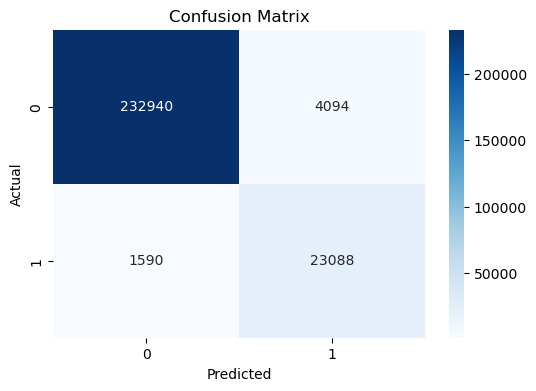

Precision: 0.85
Recall: 0.94
F1-Score: 0.89
ROC-AUC: 0.96


In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Precision, Recall, F1-Score
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

In [117]:
model = Sequential()

# Input layer
model.add(Dense(64, input_dim=X_train_with_error.shape[1], activation='relu'))
model.add(Dropout(0.4))  # Regularization

# Hidden layers
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Optional, to improve training stability
model.add(Dropout(0.4))

model.add(Dense(16, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [118]:
model.fit(X_train_with_error, Y_train, 
          epochs=50, 
          batch_size=128, 
          validation_data=(X_test_with_error, Y_test)
         )

Epoch 1/50
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - Precision: 0.6577 - Recall: 0.8301 - accuracy: 0.9335 - loss: 0.1532 - val_Precision: 0.8318 - val_Recall: 0.8887 - val_accuracy: 0.9726 - val_loss: 0.0617
Epoch 2/50
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - Precision: 0.8079 - Recall: 0.9179 - accuracy: 0.9718 - loss: 0.0638 - val_Precision: 0.8104 - val_Recall: 0.9385 - val_accuracy: 0.9735 - val_loss: 0.0597
Epoch 3/50
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - Precision: 0.8144 - Recall: 0.9174 - accuracy: 0.9726 - loss: 0.0616 - val_Precision: 0.8200 - val_Recall: 0.9318 - val_accuracy: 0.9743 - val_loss: 0.0583
Epoch 4/50
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - Precision: 0.8200 - Recall: 0.9194 - accuracy: 0.9733 - loss: 0.0606 - val_Precision: 0.8389 - val_Recall: 0.9069 - val_accuracy: 0.9748 - val_loss: 0.0582
Epoch 5/50
6134/6134 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - Precision: 0.8210 - Recall: 0.9154 - accuracy: 0.9731 - loss: 0.0603 - val_Precision: 0.8246 - 

KeyboardInterrupt: 

In [120]:
Y_pred_prob = model.predict(X_test_with_error)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 8s 889us/step


In [135]:
Y_pred = (Y_pred_prob > 0.485).astype(int).flatten()

Accuracy: 97.59%

Confusion Matrix:
[[232585   4449]
 [  1868  22810]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.84      0.92      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.91      0.95      0.93    261712
weighted avg       0.98      0.98      0.98    261712



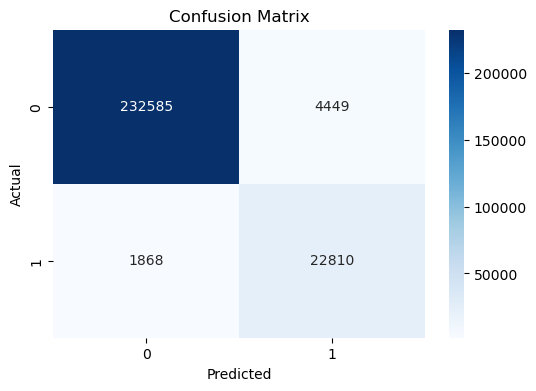

In [136]:
# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()